### Goal:
Time Series Forcasting & Analysis of traffice on wikipedia pages
### About Dataset:
The training dataset consists of approximately 7.6k time series. Each of these time series represent a number of daily views of a different Wikipedia article, starting from July, 1st, 2015 up until December 31st, 2016.
### Solution Steps:
---
    1) A CLOSER LOOK AT DATA
       1.1) Import libraries & Load Load data 
       1.2) What Features we have in data set
       
    2) WHAT FEATURES WE CAN EXTRACT
       2.1) Get Name, Language, Agent, Access from feature 'PAGE'
       2.2) Get summary of wikipedia articles using Wiki-Pedia API
       2.3) tf-idf (term frequency & inverse document frequency) of wikipedia articles
       2.4) Knn to find neighbours & compare the neighbour lists of articles
       2.5) cluster similar articles together
       2.6) Can we find the Topics/Cateogries of articles?
       2.7) Extract the dates based features
       
    3) VISUALIZATION
       3.1) Countplots for extracted features
       3.2) Plotting Time-Series for some individual articles views
       3.3) Views on weekdays/weekends and per month
       3.4) Views based on Language & article category
   
    4) MODELS
       4.1) Divide Train-Set & Validation-Set
       4.2) Fit ARIMA & Prophet Models- Visualize the predictions of validations set 
       
    5) PERFORMANCE-RMSE
    
    6) CONCLUSION & Future Work
---
       
       

### 1) A CLOSER LOOK AT DATA
####       1.1) Import libraries & Load Load data 

In [1]:
from scipy.stats import mode
from scipy import stats
from datetime import datetime
import plotly 
import calendar as calendar
import wikipedia as wiki
import graphlab as gl
import pandas as pd
import numpy as np
import warnings
import random
import requests
plotly.tools.set_credentials_file(username='livehogg', api_key='sgzVsiBGa1siF1to72t0')
warnings.filterwarnings('ignore')
data = pd.read_csv("wiki_data.csv")
#delete the additional index column
del data[u'Unnamed: 0']
print(data.info())
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7603 entries, 0 to 7602
Columns: 551 entries, Page to 2016-12-31
dtypes: int64(550), object(1)
memory usage: 32.0+ MB
None


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,Carlos_Villagrán_es.wikipedia.org_all-access_a...,404,459,479,507,593,489,503,515,499,...,541,690,655,723,669,797,978,928,830,741
1,Carta_formal_es.wikipedia.org_all-access_all-a...,594,555,361,167,214,439,466,374,368,...,69,44,32,25,40,55,69,67,50,37
2,Murder_of_James_Bulger_en.wikipedia.org_all-ac...,49,49,47,47,37,45,34,47,76,...,37,90,56,27,33,46,39,52,42,51
3,Marco_Rubio_en.wikipedia.org_all-access_spider,169,58,33,63,85,142,206,232,243,...,55,117,93,79,61,80,76,87,75,62
4,Julien_Clerc_fr.wikipedia.org_desktop_all-agents,190,241,250,192,224,237,399,461,261,...,322,1272,448,309,475,343,412,323,404,411


#### 1.2) What Features we have in data set
550 features are the dates which gives the number of views on a perticular page for a give data.One Feature "Page" which contains identification of the page, we can use this Page feature to generate the new useful features which can provide use more meaningful insights about data. 

### 2) WHAT FEATURES WE CAN EXTRACT
####   2.1) Get Name, Language, Agent, Access from feature 'PAGE'
The feature Page contains the type of access (e.g. desktop) and type of agent (e.g. spider). In other words, each article name has the following format: 
'name-of-page_language_wikipedia.org_access_agent' 

In [2]:
#extract the features
wiki_pedia=data[data['Page'].apply(lambda x: 'wikipedia' in x)]
wiki_pedia["Lang"]=wiki_pedia['Page'].apply(lambda x: x.split('.wikipedia')[0][-2:])
wiki_pedia["Name"]=wiki_pedia['Page'].apply(lambda x: x.split('.wikipedia')[0][:-3])
wiki_pedia["Agent"]=wiki_pedia['Page'].apply(lambda x: x.split('_')[len(x.split('_'))-1])
wiki_pedia["Access"]=wiki_pedia['Page'].apply(lambda x: x.split('_')[len(x.split('_'))-2])
print(wiki_pedia['Lang'].unique())
print(wiki_pedia['Agent'].unique())
print(wiki_pedia['Access'].unique())
wiki_pedia.head()

['es' 'en' 'fr' 'de' 'ja' 'zh' 'ru']
['all-agents' 'spider']
['all-access' 'desktop' 'mobile-web']


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Lang,Name,Agent,Access
0,Carlos_Villagrán_es.wikipedia.org_all-access_a...,404,459,479,507,593,489,503,515,499,...,669,797,978,928,830,741,es,Carlos_Villagrán,all-agents,all-access
1,Carta_formal_es.wikipedia.org_all-access_all-a...,594,555,361,167,214,439,466,374,368,...,40,55,69,67,50,37,es,Carta_formal,all-agents,all-access
2,Murder_of_James_Bulger_en.wikipedia.org_all-ac...,49,49,47,47,37,45,34,47,76,...,33,46,39,52,42,51,en,Murder_of_James_Bulger,spider,all-access
3,Marco_Rubio_en.wikipedia.org_all-access_spider,169,58,33,63,85,142,206,232,243,...,61,80,76,87,75,62,en,Marco_Rubio,spider,all-access
4,Julien_Clerc_fr.wikipedia.org_desktop_all-agents,190,241,250,192,224,237,399,461,261,...,475,343,412,323,404,411,fr,Julien_Clerc,all-agents,desktop


#### 2.2) Get summary of wikipedia articles using Wiki-Pedia API

In [ ]:
count=0
def get_summary(name):
    global count
    count+=1
    try:
        name=(name.decode('utf-8')).replace("_"," ")
        res=wiki.search(name)
        if len(res)==0:
            return 'none'
        summary = wiki.summary(res[0])
        return summary
    except wiki.exceptions.PageError as e:
        return 'none'
    except wiki.exceptions.DisambiguationError as e:
        try: 
            return wiki.summary(e.options[0])
        except:
            return 'none'           

wiki_pedia['Summary']=wiki_pedia['Name'].apply(lambda x: get_summary(x))

Lets see what summary we have fetched here!!

In [3]:
for i in [0,3,232,3543,324]:
    print("Page:",wiki_pedia['Name'][i])
    print(wiki_pedia["Summary"][i][0:300])
    print("************************************************************************")

('Page:', 'Carlos_Villagr\xc3\xa1n')
Carlos Villagrán Eslava (born 12 January 1943) is a Mexican actor, comedian, and former journalist best known for playing Quico in the Televisa sitcom El Chavo del Ocho and the Telerey sitcom ¡Ah qué Kiko!.\n\n
************************************************************************
('Page:', 'Marco_Rubio')
Marco Antonio Rubio (; born May 28, 1971) is an American politician, attorney, and the junior United States Senator for Florida. A Republican, he previously served as Speaker of the Florida House of Representatives.\nRubio is a Cuban American from Miami, with a B.A. from the University of Florida an
************************************************************************
('Page:', 'Christmas')
Christmas is an annual festival commemorating the birth of Jesus Christ, observed primarily on December 25 as a religious and cultural celebration among billions of people around the world.\nA feast central to the Christian liturgical year, it is preceded b

#### 2.3) tf-idf (term frequency & inverse document frequency) of wikipedia articles
we use tf-idf to assign a numerical significance to each word token in an article. Here we will use Graphlab libraries to calculate the tf-idf for each of the wiki-pedia summary articles.

In [4]:
#create an sframe with page-name & summary
gl_data=gl.SFrame({'Name':wiki_pedia['Name'].astype(str),'Summary':wiki_pedia['Summary'].astype(str)})
#calculate the new feature/column using graphlab's text analytics library
gl_data['tfidf']=gl.text_analytics.tf_idf(gl_data['Summary'])
gl_data.head(5)

This non-commercial license of GraphLab Create for academic use is assigned to dsjhala@iu.edu and will expire on May 31, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1515900197.log


Name,Summary,tfidf
Carlos_Villagrán,Carlos Villagrán Eslava(born 12 January 1943 ...,"{'and':0.2615462650378427, ' ..."
Carta_formal,"Magna Carta Libertatum(Medieval Latin for ""the ...","{'all':4.170226515469388, ..."
Murder_of_James_Bulger,James Patrick Bulger (16March 1990 – 12 ...,"{'kirkby,':8.936298185228436, ..."
Marco_Rubio,"Marco Antonio Rubio (;born May 28, 1971) is an ...","{'b.a.':8.24315100466849, ..."
Julien_Clerc,"Julien Clerc, pronounced[ʒy.ljɛ̃ klɛʁ], (4 ...","{'a':0.10036039590860048, ..."


Lets see what tf-idf feature contains!

In [5]:
print gl_data['Summary'][0]
print("*************************************")
print gl_data['tfidf'][0]

Carlos Villagrán Eslava (born 12 January 1943) is a Mexican actor, comedian, and former journalist best known for playing Quico in the Televisa sitcom El Chavo del Ocho and the Telerey sitcom ¡Ah qué Kiko!.\n\n
*************************************
{'and': 0.2615462650378427, 'el': 4.425438678711586, '1943)': 6.103084841172221, 'mexican': 3.9526915635201, 'is': 0.1660143661300374, 'ocho': 8.24315100466849, 'televisa': 6.990388036173123, '(born': 1.8313327369585943, 'in': 0.16741285909357342, 'best': 2.0126695570900095, 'for': 0.5872869870524347, 'kiko!.\\n\\n': 8.936298185228436, 'qu\xc3\xa9': 8.24315100466849, 'eslava': 8.936298185228436, 'villagr\xc3\xa1n': 8.936298185228436, '\xc2\xa1ah': 8.936298185228436, 'known': 1.370504902799922, 'chavo': 7.550003824108546, 'former': 2.4842492307912107, 'a': 0.10036039590860048, '12': 3.5157631859561507, 'january': 2.1724132766660014, 'actor,': 3.3950346400700107, 'sitcom': 9.319264132424763, 'comedian,': 5.004472552504111, 'del': 4.30156919699

#### 2.4) Knn to find neighbours &  compare the neighbour lists of articles
using tf-idf we can calculate the distance among articles & KNN model can be used to find the neighbours of an article in a perticular radius. we will use this idea to create & merge clusters in upcomming steps.

Lets calculate the cosine distance between few similar & non-similar articles to get insights of idea!

In [6]:
print("Obama & Bill Clinton",gl.distances.cosine(gl_data['tfidf'][gl_data['Name']=='Barack_Obama'][0],gl_data['tfidf'][gl_data['Name']=='Bill_Clinton'][0]))
print("Obama & Ronaldo",gl.distances.cosine(gl_data['tfidf'][gl_data['Name']=='Barack_Obama'][0],gl_data['tfidf'][gl_data['Name']=='Ronaldo'][0]))
print("Dragon Ball & Obama",gl.distances.cosine(gl_data['tfidf'][gl_data['Name']=='Barack_Obama'][0],gl_data['tfidf'][gl_data['Name']=='Dragon_Ball'][0]))
print("Dragon Ball & Aneme",gl.distances.cosine(gl_data['tfidf'][gl_data['Name']=='Dragon_Ball'][0],gl_data['tfidf'][gl_data['Name']=='Anime'][0]))

('Obama & Bill Clinton', 0.8683704387985389)
('Obama & Ronaldo', 0.9440298393365467)
('Dragon Ball & Obama', 0.9840831326682282)
('Dragon Ball & Aneme', 0.9155446962667227)


Lets have a look at neighbours of few articles!

In [ ]:
# train the knn model on tf-idf
knn=gl.nearest_neighbors.create(gl_data,features=['tfidf'],label='Name')
print("Lets see who are the neighbours of Bush")
knn.query(gl_data[gl_data['Name']=='George_H._W._Bush'],k=len(gl_data),radius=0.90).print_rows(num_rows=len(gl_data))
print("Lets see who are the neighbours of Barack Obama")
knn.query(gl_data[gl_data['Name']=='Barack_Obama'],k=len(gl_data),radius=0.90).print_rows(num_rows=len(gl_data))
#store the references & count the number of matches
list1=list(knn.query(gl_data[gl_data['Name']=='Barack_Obama'],k=len(gl_data),radius=0.90)['reference_label'])
list2=list(knn.query(gl_data[gl_data['Name']=='George_H._W._Bush'],k=len(gl_data),radius=0.90)['reference_label'])
counter=0
for item in list1:
    if item in list2:
        counter+=1
print("total_Match",counter)

In [8]:
print("Lets see who are the neighbours of Bush")
knn.query(gl_data[gl_data['Name']=='George_H._W._Bush'],k=len(gl_data),radius=0.90).print_rows(num_rows=len(gl_data))
print("Lets see who are the neighbours Julien_Clerc")
knn.query(gl_data[gl_data['Name']=='Julien_Clerc'],k=len(gl_data),radius=0.90).print_rows(num_rows=len(gl_data))
#store the references & count the number of matches
list1=list(knn.query(gl_data[gl_data['Name']=='George_H._W._Bush'],k=len(gl_data),radius=0.90)['reference_label'])
list2=list(knn.query(gl_data[gl_data['Name']=='Julien_Clerc'],k=len(gl_data),radius=0.90)['reference_label'])
counter=0
for item in list1:
    if item in list2:
        counter+=1
print("total_Match",counter)

Lets see who are the neighbours of Bush


Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0131527   | 44.639ms     |

| Done         |         | 100         | 123.876ms    |

+--------------+---------+-------------+--------------+

+-------------+-------------------------------+----------------+------+
| query_label |        reference_label        |    distance    | rank |
+-------------+-------------------------------+----------------+------+
|      0      |       George_H._W._Bush       |      0.0       |  1   |
|      0      |         George_W._Bush        | 0.793650793651 |  2   |
|      0      |          Bill_Clinton         | 0.827788649706 |  3   |
|      0      |            Bob_Dole           | 0.838779956427 |  4   |
|      0      |         Richard_Nixon         | 0.845261121857 |  5   |
|      0      |          Gerald_Ford          | 0.847494553377 |  6   |
|      0      | United_States_presidential... | 0.855652173913 |  7   |
|      0      | United_States_presidential... | 0.860619469027 |  8   |
|      0      |   Franklin_Delano_Roosevelt   | 0.861852433281 |  9   |
|      0      | United_States_presidential... | 0.863543788187 |  10  |
|      0      |           Joe_Biden           | 0.866156787763 |

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0131527   | 24.669ms     |

| Done         |         | 100         | 82.112ms     |

+--------------+---------+-------------+--------------+

+-------------+--------------------------------+----------------+------+
| query_label |        reference_label         |    distance    | rank |
+-------------+--------------------------------+----------------+------+
|      0      |          Julien_Clerc          |      0.0       |  1   |
|      0      |  Les_Vestiges_du_jour_(film)   | 0.809523809524 |  2   |
|      0      |         Nora_Arnezeder         | 0.814814814815 |  3   |
|      0      |         Marlène_Jobert         | 0.814814814815 |  4   |
|      0      |             吳映潔             | 0.818181818182 |  5   |
|      0      |             金城武             | 0.821428571429 |  6   |
|      0      |         Laurent_Voulzy         | 0.821428571429 |  7   |
|      0      |            中山美穂            | 0.827586206897 |  8   |
|      0      |       Clémentine_Célarié       | 0.827586206897 |  9   |
|      0      |         Jeff_Panacloc          | 0.828571428571 |  10  |
|      0      |         Juliette_Gréco         | 0.8333333333

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0131527   | 33.605ms     |

| Done         |         | 100         | 97.859ms     |

+--------------+---------+-------------+--------------+

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0131527   | 21.559ms     |

| Done         |         | 100         | 103.147ms    |

+--------------+---------+-------------+--------------+

('total_Match', 0)


#### 2.5) cluster similar articles together
Code in below cell will find the neighbours for articles, create clusters of similar articles & also will merge clusters clusters have a lot in common.

In [ ]:
from random import *
from scipy.stats import mode
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
knn=gl.nearest_neighbors.create(gl_data,features=['tfidf'],label='Name')
wiki_pedia['Category']=np.zeros(len(wiki_pedia))
cat=0
names=list(wiki_pedia['Name'])
left=len(names)
removed=[]

for name in names[0:]:
    j=len(names)
    l=len(removed)
#    print("Get neighbours of:",name)
    if name not in names:
        continue
     
    try: 
        neighbours=list(knn.query(gl_data[gl_data['Name']== name],k=len(gl_data),radius=0.895)['reference_label'])  
    except:
#        print("knn query didn't work!!")
        removed.append(name)
        names.remove(name)
        continue
#    print("members in cluster",len(neighbours))    
    temp=0
    rm=0.0
    nrm=0.0
    rid=[]
    ctg=[]
    
    if len(neighbours)==0.0:
        removed.append(name)
        names.remove(name)
#        print("0 neighbours so no new clusters created nor assigned ")
#        print("total processed pages:",len(removed))
#        print("we have to process following more pages:",len(names))
#        print("################################################################################################")
        continue
    
    else:
        for n in neighbours:
            if n in removed:
                rm+=1
                c=int(wiki_pedia['Category'][wiki_pedia['Name']==n])
                ctg.append(c)
                continue 
                
            else:
                nrm+=1
                rid.append(n)
                
    if nrm==0.0:
        wiki_pedia['Category'][wiki_pedia['Name']==name]=mode(ctg)[0][0]
        names.remove(name)
        continue
   
    if (rm>0.55*nrm):
#        print("RM>>NRM")
#        print("assignmed category:",mode(ctg)[0][0])

        for n in rid:
            wiki_pedia['Category'][wiki_pedia['Name']==n]=mode(ctg)[0][0]
            removed.append(n)
            try:
                names.remove(n)
            except:
                pass
        
    else:
        print("NRM>>RM")
        cat+=1
        print("New Category",cat)
        for n in rid:
            wiki_pedia['Category'][wiki_pedia['Name']==n]=cat
            removed.append(n)
            try:
                names.remove(n)
            except:
                pass
        wiki_pedia['Category'][wiki_pedia['Name']==name]=cat
    
#    print("This page has following clustered neighours:",rm)    
#    print("This page has following unclustered neighours:",nrm)   
#    print("Processed till now:",len(removed))
    print("Remaining",len(names))
    print("number of clusters:",cat)
    
    if j<=len(names) or l>=len(removed):
        print("ERROR!!")
        break
    
#    print("################################################################################################")     

#### 2.6) Can we find the Topics/Cateogries of articles?
Yes we get an impression about category of articlse such as politics/celebrities/health by looking few random articles from each cluster. 

Lets have a sneak peak into our clusters to know the topics/categories

In [ ]:
#Lets Get rid of the clusters(put them into misllanous category 0.0) which have very few items in them
category=[]
for c in wiki_pedia["Category"].unique():
    category.append(int(c))

for category in category:
    # Get rid of the clusters with less than 22 items
    if len(wiki_pedia[wiki_pedia['Category']==category])<22:
        wiki_pedia['Category'][wiki_pedia['Category']==category]=0


for i in wiki_pedia['Category'].unique():
    print("Articles for category No.: ",i)
    k=20
    for x in wiki_pedia['Summary'][wiki_pedia['Category']==i]:
        
        k+=1
        try:
            print x[0:300]
        except:
            continue
        print("-------------------")
        if k==50:
              break
    print("******************************************************************")

##### Merge the clusters with high similarity. So as we can see that for :

#### By looking at above samples from each category we can infer the topics of these clusters:
1)- Personalities: Actors, Singers, Sports person

4)- Politics: Government, Kingdom, Social Activists

5)- Actors, Singers, TV, Film // can be merged with 1)

7)- Political personalities// can be merged with 4)

8)- Entertainment: Films & Tv-Series

9)- Movies, Novels, Characters // can be merged with 8)

10)- Authors, Actors, Actresses // can be merged with 1

12)- The List // top 10, the list of comedians,singles,releases in 2018

13)- Bad Cluser!!
15)- Bad Cluster!!

17)- Sports: players & events

18)- Personalities : Can be merged with 1)

19)- Sports// can be merged with 17

24)- Places// countries & Cities

In [7]:
wiki_pedia['Category'][wiki_pedia['Category']==5]=1
wiki_pedia['Category'][wiki_pedia['Category']==10]=1
wiki_pedia['Category'][wiki_pedia['Category']==7]=4
wiki_pedia['Category'][wiki_pedia['Category']==9]=8
wiki_pedia['Category'][wiki_pedia['Category']==13]=0.0
wiki_pedia['Category'][wiki_pedia['Category']==15]=0.0
wiki_pedia['Category'][wiki_pedia['Category']==18]=1
wiki_pedia['Category'][wiki_pedia['Category']==19]=17
print ("Number of clusters now",len(wiki_pedia['Category'].unique()))
#How Many Entries we have in each category
for i in wiki_pedia['Category'].unique():
    print(i,len(wiki_pedia[wiki_pedia['Category']==i]))
    
wiki_pedia["Topic"]=['unidentified']*len(wiki_pedia)
for i in wiki_pedia['Category'].unique():
    if i==0:
        wiki_pedia['Topic'][wiki_pedia['Category']==i]='Assorted'
    if i==1:
        wiki_pedia['Topic'][wiki_pedia['Category']==i]='Celebs'
    if i==4:
        wiki_pedia['Topic'][wiki_pedia['Category']==i]='Politics'
    if i==8:
        wiki_pedia['Topic'][wiki_pedia['Category']==i]='Movies/Tv'
    if i==12:
        wiki_pedia['Topic'][wiki_pedia['Category']==i]='TheList'
    if i==17:
        wiki_pedia['Topic'][wiki_pedia['Category']==i]='Sports'
    if i==24:
        wiki_pedia['Topic'][wiki_pedia['Category']==i]='Places'
        
wiki_pedia['Topic'].unique()    

('Number of clusters now', 7)
(1.0, 4758)
(0.0, 699)
(4.0, 162)
(8.0, 1480)
(12.0, 205)
(17.0, 139)
(24.0, 160)


array(['Celebs', 'Assorted', 'Politics', 'Movies/Tv', 'TheList', 'Sports',
       'Places'], dtype=object)

#### 2.7) Extract the dates based features
In order to achieve this we need to pivot our dataframe

In [10]:
wiki_dates = pd.melt(wiki_pedia, id_vars=["Page", "Name","Lang","Agent","Access","Summary","Category","Topic"], 
                  var_name="Date", value_name="Views").reset_index(drop=True)
wiki_dates.head(4)

,Page,Name,Lang,Agent,Access,Summary,Category,Topic,Date,Views
0,Carlos_Villagrán_es.wikipedia.org_all-access_a...,Carlos_Villagrán,es,all-agents,all-access,Carlos Villagrán Eslava (born 12 January 1943)...,1.0,Celebs,2015-07-01,404
1,Carta_formal_es.wikipedia.org_all-access_all-a...,Carta_formal,es,all-agents,all-access,"Magna Carta Libertatum (Medieval Latin for ""th...",0.0,Assorted,2015-07-01,594
2,Murder_of_James_Bulger_en.wikipedia.org_all-ac...,Murder_of_James_Bulger,en,spider,all-access,James Patrick Bulger (16 March 1990 – 12 Febru...,0.0,Assorted,2015-07-01,49
3,Marco_Rubio_en.wikipedia.org_all-access_spider,Marco_Rubio,en,spider,all-access,"Marco Antonio Rubio (; born May 28, 1971) is a...",4.0,Politics,2015-07-01,169


In [11]:
wiki_dates['Day']=wiki_dates['Date'].apply(lambda x:  calendar.day_name[datetime.strptime(x, '%Y-%m-%d').weekday()])
wiki_dates['Month']=wiki_dates['Date'].apply(lambda x:  calendar.month_name[int(x[5:7])])
wiki_dates.head()

,Page,Name,Lang,Agent,Access,Summary,Category,Topic,Date,Views,Day,Month
0,Carlos_Villagrán_es.wikipedia.org_all-access_a...,Carlos_Villagrán,es,all-agents,all-access,Carlos Villagrán Eslava (born 12 January 1943)...,1.0,Celebs,2015-07-01,404,Wednesday,July
1,Carta_formal_es.wikipedia.org_all-access_all-a...,Carta_formal,es,all-agents,all-access,"Magna Carta Libertatum (Medieval Latin for ""th...",0.0,Assorted,2015-07-01,594,Wednesday,July
2,Murder_of_James_Bulger_en.wikipedia.org_all-ac...,Murder_of_James_Bulger,en,spider,all-access,James Patrick Bulger (16 March 1990 – 12 Febru...,0.0,Assorted,2015-07-01,49,Wednesday,July
3,Marco_Rubio_en.wikipedia.org_all-access_spider,Marco_Rubio,en,spider,all-access,"Marco Antonio Rubio (; born May 28, 1971) is a...",4.0,Politics,2015-07-01,169,Wednesday,July
4,Julien_Clerc_fr.wikipedia.org_desktop_all-agents,Julien_Clerc,fr,all-agents,desktop,"Julien Clerc, pronounced [ʒy.ljɛ̃ klɛʁ], (4 Oc...",1.0,Celebs,2015-07-01,190,Wednesday,July


### 3) VISUALIZATION
####       3.1) Plots for extracted features

This non-commercial license of GraphLab Create for academic use is assigned to dsjhala@iu.edu and will expire on May 31, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1516220050.log


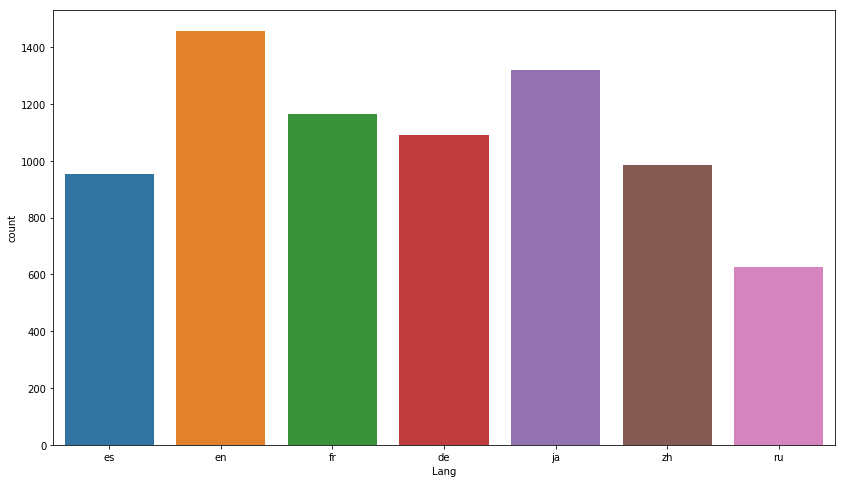

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Language
Language=pd.DataFrame(columns=['Lang','Count'])
Language["Lang"]=wiki_pedia['Lang'].unique()
temp=[]
for l in Language["Lang"]:
    temp.append(len(wiki_pedia[wiki_pedia["Lang"]==l]))
Language['Count']=temp
#Agent
Agent=pd.DataFrame(columns=['Agent','Count'])
Agent["Agent"]=wiki_pedia['Agent'].unique()
temp=[]
for l in Agent["Agent"]:
    temp.append(len(wiki_pedia[wiki_pedia["Agent"]==l]))
Agent['Count']=temp
#Devices
Access=pd.DataFrame(columns=['Access','Count'])
Access["Access"]=wiki_pedia['Access'].unique()
temp=[]
for l in Access["Access"]:
    temp.append(len(wiki_pedia[wiki_pedia["Access"]==l]))
Access['Count']=temp
#Topics
Topics=pd.DataFrame(columns=['Topic','Count'])
Topics["Topic"]=wiki_pedia['Topic'].unique()
temp=[]
for l in Topics["Topic"]:
    temp.append(len(wiki_pedia[wiki_pedia["Topic"]==l]))
Topics['Count']=temp

fig, (ax1) = plt.subplots(1,1,figsize=(14,8))
sns.countplot(wiki_pedia['Lang'],ax=ax1)
plt.show()
plt.close()


In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
labels = Topics['Topic']
values = Topics['Count']
trace = go.Pie(labels=labels, values=values)
py.iplot([trace], filename='basic_pie_chart')

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
labels = Access['Access']
values = Access['Count']
trace = go.Pie(labels=labels, values=values)
py.iplot([trace], filename='basic_pie_chart')

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
labels = Agent['Agent']
values = Agent['Count']
trace = go.Pie(labels=labels, values=values)
py.iplot([trace], filename='basic_pie_chart')

#### 3.2) Plotting Time-Series for some individual articles views

('Max Views', 3779597    2016-11-09
Name: Date, dtype: object)
President Obama on 2016-11-09 spoke from the White House on the election of Donald Trump to the presidency.


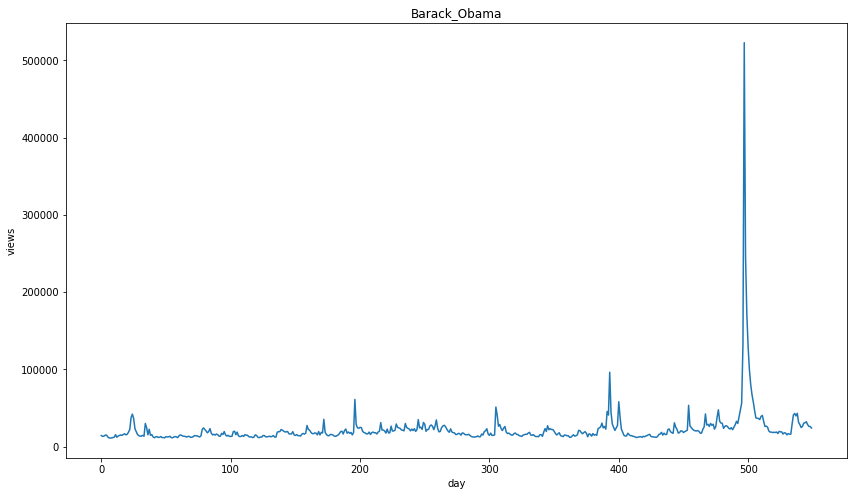

('Max Views', '2016-05-13\n')
Movie 'Money_Monster' was released on 2016-05-13


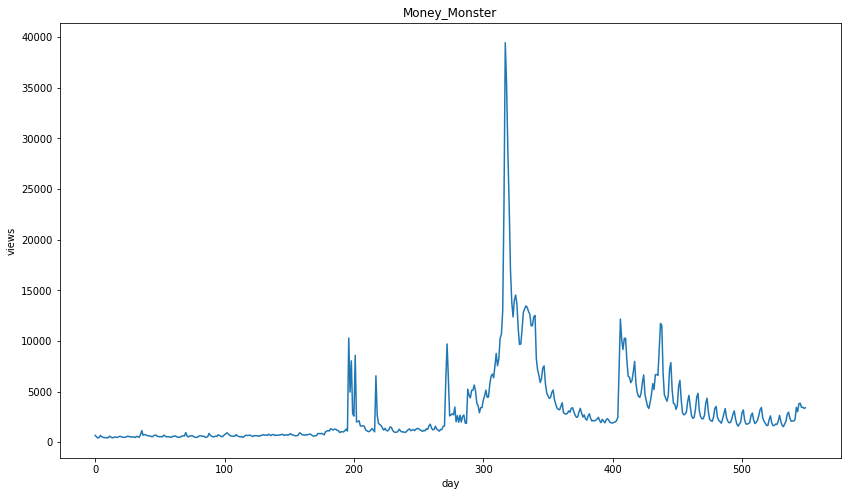

In [21]:
print("Max Views",wiki_dates['Date'][wiki_dates['Views']==max(wiki_dates['Views'][wiki_dates['Name']=='Barack_Obama'])])
print "President Obama on 2016-11-09 spoke from the White House on the election of Donald Trump to the presidency."
fig = plt.figure(1,figsize=(14,8))
plt.plot(range(len(wiki_dates[wiki_dates['Name']=='Barack_Obama'])),wiki_dates['Views'][wiki_dates['Name']=='Barack_Obama'])
plt.xlabel('day')
plt.ylabel('views')
plt.title('Barack_Obama')
plt.show()
print('Max Views',str(wiki_dates['Date'][wiki_dates['Views']==max(wiki_dates['Views'][wiki_dates['Name']=='Money_Monster'])])[33:44])
print "Movie 'Money_Monster' was released on 2016-05-13"
fig = plt.figure(1,figsize=(14,8))
plt.plot(range(len(wiki_dates[wiki_dates['Name']=='Money_Monster'])),wiki_dates['Views'][wiki_dates['Name']=='Money_Monster'])
plt.xlabel('day')
plt.ylabel('views')
plt.title('Money_Monster')
plt.show()

#### 3.3) Views on weekdays/weekends and per month

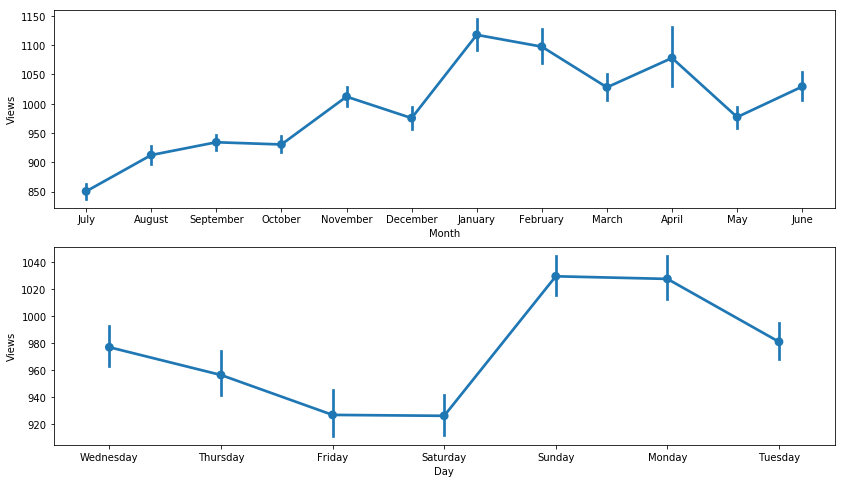

In [22]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8))
sns.pointplot(x='Month',y='Views',data=wiki_dates,ax=ax1)
sns.pointplot(x='Day',y='Views',data=wiki_dates,ax=ax2)

#### 3.4) Views based on Language & Article Category

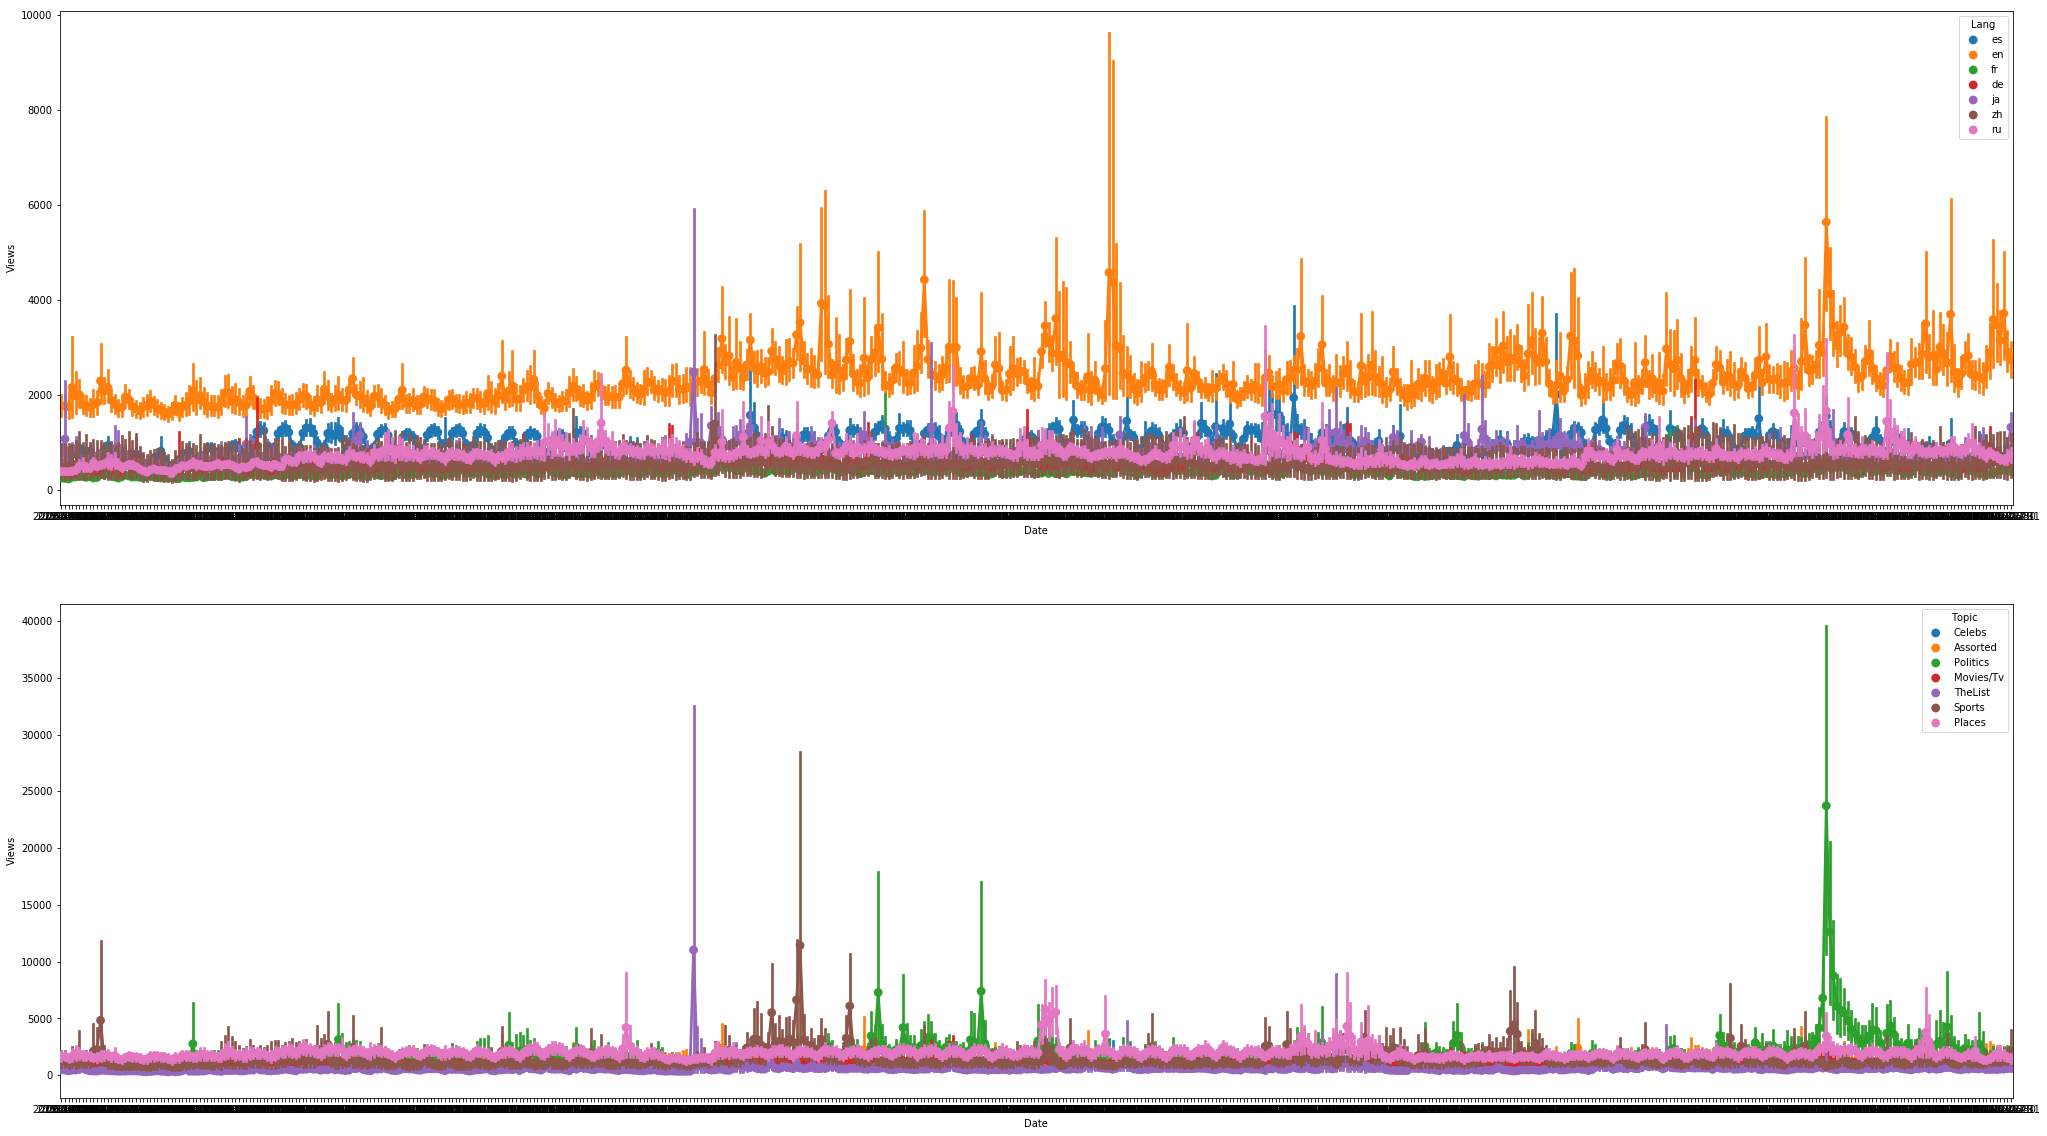

In [26]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(35,20))
sns.pointplot(x="Date", y="Views",hue="Lang",data=wiki_dates,ax=ax1)
sns.pointplot(x="Date", y="Views",hue="Topic",data=wiki_dates,ax=ax2)

### 4) MODELS
####   4.1) Divide Train-Set & Validation-Set
Now we will be working with only one key feature which is 'Date' colmns. Usually in normal machine learning we divide our dataset row wise but in this case we will divide it column wise because each row in the dataset is responsible for its own views prediction on future dates, none of the rows will help in prediction of other rows.
#### Training Set

In [3]:
train_set=wiki_pedia.iloc[:,range(1,401)]
train_set.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-07-25,2016-07-26,2016-07-27,2016-07-28,2016-07-29,2016-07-30,2016-07-31,2016-08-01,2016-08-02,2016-08-03
0,404,459,479,507,593,489,503,515,499,467,...,4543,1606,917,813,777,716,742,721,537,585
1,594,555,361,167,214,439,466,374,368,241,...,199,320,283,278,199,143,137,236,338,300
2,49,49,47,47,37,45,34,47,76,43,...,65,40,50,37,49,44,31,48,54,27
3,169,58,33,63,85,142,206,232,243,187,...,106,124,83,160,187,168,103,141,89,97
4,190,241,250,192,224,237,399,461,261,262,...,237,165,147,175,174,171,472,284,238,464


#### Validation Set

In [4]:
val_set=wiki_pedia.iloc[:,range(401,551)]
val_set.head()

,2016-08-04,2016-08-05,2016-08-06,2016-08-07,2016-08-08,2016-08-09,2016-08-10,2016-08-11,2016-08-12,2016-08-13,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,541,456,452,526,445,516,523,436,446,409,...,541,690,655,723,669,797,978,928,830,741
1,363,244,145,159,350,372,365,350,220,134,...,69,44,32,25,40,55,69,67,50,37
2,22,28,26,30,26,32,53,41,35,21,...,37,90,56,27,33,46,39,52,42,51
3,82,87,54,77,131,95,139,79,93,96,...,55,117,93,79,61,80,76,87,75,62
4,322,249,168,171,193,283,224,202,183,155,...,322,1272,448,309,475,343,412,323,404,411


In [5]:
#complete set
com=wiki_pedia.iloc[:,range(1,551)]

In [25]:
from fbprophet import Prophet
from pandas import Series
from statsmodels.tsa.stattools import adfuller
import random as r
ndf=pd.DataFrame(columns=['ds','y'])
stationary=[]

for i in r.sample(range(0, len(wiki_pedia)), 200):
    X = com.iloc[i]
    result = adfuller(X)
    if result[1]<=0.5:
        stationary.append(i)

print ("We will analyse "+str(len(stationary))+" stationary series")

We will analyse 196 stationary series


#### 4.2) Fit ARIMA & Prophet Models- Visualize the predictions of validations set
Lets See how ARIMA & Phrophet Model fits on some random articles 

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
ndf=pd.DataFrame(columns=['ds','y'])
%matplotlib inline
Arima_Pred={}
Prophet_Pred={}
Mean_Pred={}
for i in stationary:
    print("Time Series Plot for Page:",wiki_pedia["Name"][i])
    data=np.array(train_set.iloc[i],'f')
    actual=np.array(com.iloc[i],'f')
    ndf['ds']=train_set.columns
    ndf['y']=np.array(train_set.loc[i,ndf['ds']],'f')
    m = Prophet(yearly_seasonality=True)
    m.fit(ndf);
    future = m.make_future_dataframe(periods=150)
    forecast = m.predict(future)
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[4,0,1])
            result = arima.fit(disp=False)
        except:
            try:
                arima = ARIMA(data,[2,0,2])
                result = arima.fit(disp=False)
            except:
                continue
    #print(result.params)
    pred = result.predict(1,552)
    Arima_Pred[i]=pred[0:550]
    x = [j for j in range(554)]
    plt.figure(figsize=(14,8))
    Prophet_Pred[i]=forecast['yhat'][0:550]
    Mean_Pred[i]=[np.mean(actual)]*len(actual)
    plt.plot(forecast['yhat'],label="Prophet")
    plt.plot(x[2:len(actual)],actual[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()
    plt.close()

### 5) PERFORMANCE- RMSE
We will be using root mean squared error as performance metric

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
Arima_Mse=[]
Prophet_Mse=[]
Mean_Mse=[]
for m in stationary:
    try:
        prophet=np.array(Prophet_Pred[m])
        arima=np.array(Arima_Pred[m])
        mean=np.array(Mean_Pred[m])
        Arima_Mse.append(sqrt(mean_squared_error(actual , arima)))
        Prophet_Mse.append(sqrt(mean_squared_error(actual , prophet)))
        Mean_Mse.append(sqrt(mean_squared_error(actual , mean)))

    except:
        continue

In [30]:
print ("ARIMA:",np.mean(Arima_Mse))
print ("Prophet:",np.mean(Prophet_Mse))
print ("Mean",np.mean(Mean_Mse))

('ARIMA:', 3140.054067975108)
('Prophet:', 3227.6227372704407)
('Mean', 2960.0294219085808)


### 6) CONCLUSION & Future Work
##### 1) Phrophet shows better variablity in the prediction part of timerseries where as ARIMA mostly looks like are linear fit. 

##### 2) Can we analyze on which type of series Arima is performing better than Prophet & vice versa.

##### 3) Most of the Pages have Stationary times series.

##### 4) Performance of ARIMA can be optimized by choosing the best values for parameters p,q,d. In R programming we have packages which automatically chooses the best values for ARIMA paramters but unfortunately we don't have it in python so we have to manually tweak the parameters which might be the reason for low performace of ARIMA.

##### 5) Can we implement R's auto_arima() function in python ?